## Attempts at Enhancing Performance of qNN via Circuit Modifications

Our first approach to improve performance of qNN model prediction is to run more EDA on our training data so as to inform our qNN architecture modification.

In [1]:
#import packages
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import keras
import math

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from keras.datasets import mnist

In [2]:
# Methods for EDA & data preprocessing

# define method to filter data for binary classification problem using '3' and '6' examples only
def filter36(x, y):
# Method that accepts dataset x with labels y and returns the pair (x, y) comprising only the
# data points with labels y == 3 or y == 6. Also converts labels in y to boolean value: y == 3 evaluates
# to True, and y == 6 evaluates to False
    sieve = (y == 3) | (y == 6)
    x, y = x[sieve], y[sieve] # use boolean indexing to filter examples 
    y = (y == 3) # convert y to boolean label
    return x, y

#define method for removing "contradictory" examples belonging to both classes
def rm_contradictions(x, y):
# Given data x with binary labels y, return (x, y) with examples belonging to both classes comprising y
    m = collections.defaultdict(set) # create dictionary of sets
    
    for xx, yy in zip(x, y): # iterate through data set x with labels y
        m[tuple(xx.flatten())].add(yy) # add dict item with key given by data point xx and value given by yy
    
    # initialize return values (data points with unique labels; ie belonging to '3' XOR '6')
    new_x = []
    new_y = []
    
    # begin filtering unique examples xx with label yy satisfying: yy == 3 XOR yy == 6
    for xx, yy in zip(x, y):
        labels = m[tuple(xx.flatten())] # retrieve values associated with key
        if len(labels) == 1:
           # example xx belongs to single class; keep example & label pair
            new_x.append(xx)
            new_y.append(labels.pop())
        else:
            # example xx belongs to both classes; ignore contradictory example
            pass
    # find total remaining examples per each class: label True for '3' and False for '6' (not '3')
    num3s = sum(1 for yy in new_y if yy == True) # Fixed method from tutorial -CZ
    num6s = sum(1 for yy in new_y if yy == False) # Fixed method from tutorial -CZ
    num_contradictions = sum(1 for value in m.values() if len(value) == 2)
    
    print("\n==================== FILTERING OUT CONTRADICTORY EXAMPLES ====================")
    print("\nInitial number of 3-6 training examples: ", len(x))
    print("Remaining non-contradictory 3-6 training examples: ", len(new_x))
    print("Number of 3s: ", num3s)
    print("Number of 6s: ", num6s)
    print("Number of contradictory images removed from training set: ", num_contradictions)
    
    return np.array(new_x), np.array(new_y)

Total initial training examples: 60000
Total initial test examples: 10000

==================== FILTERING OUT NON-"3"-"6" EXAMPLES ====================

Total filtered 3-6 training examples: 12049
Total filtered 3-6 test examples: 1968


Image for first training example: 


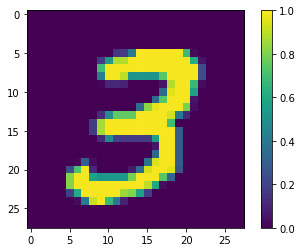



Rescaled image for first training example: 


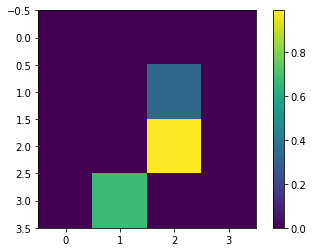


==================== FILTERING OUT CONTRADICTORY EXAMPLES ====================

Initial number of 3-6 training examples:  12049
Remaining non-contradictory 3-6 training examples:  10338
Number of 3s:  4912
Number of 6s:  5426
Number of contradictory images removed from training set:  49


In [3]:
# EDA & Data preprocessing for MNIST 3-6 Binary Classification

# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Total initial training examples:", len(x_train))
print("Total initial test examples:", len(x_test))

#rescale images to range [0.0, 1.0]
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0


# filter data
x_train, y_train = filter36(x_train, y_train)
x_test, y_test = filter36(x_test, y_test)
print("\n==================== FILTERING OUT NON-\"3\"-\"6\" EXAMPLES ====================")
print("\nTotal filtered 3-6 training examples:", len(x_train))
print("Total filtered 3-6 test examples:", len(x_test))

print("\n\nImage for first training example: ")
plt.imshow(x_train[0, :, :, 0])
plt.colorbar()
plt.show()

# resize images to 4x4 scale for quantum computers
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()
print("\n\nRescaled image for first training example: ")
plt.imshow(x_train_small[0, :, :, 0])
plt.colorbar()
plt.show()


# remove contradictory examples (x, y): for all x, y, we have y == 3 XOR y == 6
x_train_rmcon, y_train_rmcon = rm_contradictions(x_train_small, y_train)

In [4]:
# Continue EDA of training set for "3-6" binary classification problem on MNIST data
def pixel_var(X, Y, i, j):
# Computes variance for value of pixel in location (i,j) of data examples in set X per each class
# labeled by Y
    x3 = [] # store class 3 examples
    x6 = [] # store class 6 examples
    # sort through examples 
    for k in range(len(Y)):
        if(Y[k]): # evaluates true for class 3
            x3.append(X[k])
        else: # false for class 6
            x6.append(X[k])
    x3 = np.array(x3)
    x6 = np.array(x6)
    x3_var = np.var(x3[:, i, j])
    x6_var = np.var(x6[:, i, j])
    return x3_var, x6_var

def pixel_mean(X, Y, i, j):
# Computes mean for value of pixel in location (i,j) of data examples in set X per each class
# labeled by Y
    x3 = [] # store class 3 examples
    x6 = [] # store class 6 examples
    # sort through examples 
    for k in range(len(Y)):
        if(Y[k]): # evaluates true for class 3
            x3.append(X[k])
        else: # false for class 6
            x6.append(X[k])
    x3 = np.array(x3)
    x6 = np.array(x6)
    x3_mean = np.mean(x3[:, i, j])
    x6_mean = np.mean(x6[:, i, j])
    return x3_mean, x6_mean

def pixel_std(X, Y, i, j):
    # Computes standard deviation for value of pixel in location (i,j) of data examples in set X per each class
# labeled by Y
    x3 = [] # store class 3 examples
    x6 = [] # store class 6 examples
    # sort through examples 
    for k in range(len(Y)):
        if(Y[k]): # evaluates true for class 3
            x3.append(X[k])
        else: # false for class 6
            x6.append(X[k])
    x3 = np.array(x3)
    x6 = np.array(x6)
    x3_std = np.std(x3[:, i, j])
    x6_std = np.std(x6[:, i, j])
    return x3_std, x6_std

def var_per_pixel(X, Y):
# Prints variance among values for all pixels in 4x4 grids of examples in X per labels in Y
    print("\n==================== VARIANCE AMONG ALL VALUES PER EACH PIXEL IN 4x4 GRID DATA POINTS ====================")
    for i in range(4):
        for j in range(4):
            var3, var6 = pixel_var(X, Y, i, j)
            print("\nVariance among values for ("+str(i)+", "+str(j)+") pixel for class \"3\" examples: "+str(var3))
            print("Variance among values for ("+str(i)+", "+str(j)+") pixel for class \"6\" examples: \n"+str(var6))


def sort_key(p):
    return p[1]

def mag_sort(p):
    return abs(p[1])

def mean_per_pixel(X, Y):
# Prints mean values for all pixels in 4x4 grids of examples in X per labels in Y
# and locations of pixels exceeding a scaled difference of 0.5 btwn the mean values calculated 
# for class 3 and class 6 examples
    print("\n==================== MEAN VALUES PER EACH PIXEL IN 4x4 GRID DATA POINTS ====================")
    pixels = []
    max_arg = (-1, -1) # use determine pixel with largest scaled difference between means for class 3 and class 6
    maxdiff = 0 # max scaled difference between means for both classes
    for i in range(4):
        for j in range(4):
            mn3, mn6 = pixel_mean(X, Y, i, j)
            pixels.append(((i, j), abs(mn3-mn6)))
            print("\nMean value for ("+str(i)+", "+str(j)+") pixel for class \"3\" examples: "+str(mn3))
            print("Mean value for ("+str(i)+", "+str(j)+") pixel for class \"6\" examples: \n"+str(mn6))
    print("\nPixels sorted by greatest difference in mean value between both classes: ")
    pixels.sort(reverse=True, key=sort_key)
    print(pixels)
    

def std_per_pixel(X, Y):
# Prints standard dev among values for all pixels in 4x4 grids of examples in X per labels in Y
    print("\n==================== STD AMONG ALL VALUES PER EACH PIXEL IN 4x4 GRID DATA POINTS ====================")
    for i in range(4):
        for j in range(4):
            std3, std6 = pixel_std(X, Y, i, j)
            print("\nStandard deviation among values for ("+str(i)+", "+str(j)+") pixel for class \"3\" examples: "+str(std3))
            print("Standard deviation among values for ("+str(i)+", "+str(j)+") pixel for class \"6\" examples: \n"+str(std6))


def pixel_corrcoef(X, Y, i, j):
# Computes correlation coefficient between value of pixel in location (i,j) in data examples x in X and label 
# of x specified in Y
    x_ij = []
    new_y = [] # store converted boolean --> {0, 1} labels
    for x in X:
        x_ij.append(x[i][j])
    for y in Y:
        if y:
            new_y.append(1)
        else:
            new_y.append(0)
    x_ij = np.array(x_ij)
    new_y = np.array(new_y)
    x_ij = np.reshape(x_ij, newshape = new_y.shape)
    return np.corrcoef(x_ij, new_y)[0][1]

def corrcoef_per_pixel(X, Y):
# Prints correlation coefficient between target pixel value and target label for all pixels in 4x4 grids of examples in X per labels in Y
# and locations of pixels exceeding a scaled difference of 0.5 btwn the mean values calculated 
# for class 3 and class 6 examples 
    print("\n==================== CORRELATION COEFF. PER EACH PIXEL, LABEL PAIR FOR IMAGE TRAINING DATA ====================")
    pixels = []
    for i in range(4):
        for j in range(4):
            corr = pixel_corrcoef(X, Y, i, j)
            pixels.append(((i, j), corr))
            #print("\nCorrelation coefficient for values of ("+str(i)+", "+str(j)+")th pixels in target images and target labels: "+str(corr))
    pixels.sort(reverse=True, key=mag_sort)
    print("\nPixels sorted by non-increasing magnitude of correlation coeff.: ")
    print(pixels)
    
        

print("\n==================== CONTINUING EDA OF \"3\"-\"6\" MNIST TRAINING EXAMPLES ====================")
print("Shape of each training example:"+str(x_train_rmcon[0].shape))
print("Data type of each pixel:"+str(x_train_rmcon[0][0][0].dtype))
print("Example of first training point's pixel grid: \n"+str(x_train_rmcon[0]))
var_per_pixel(x_train_rmcon, y_train_rmcon)
mean_per_pixel(x_train_rmcon, y_train_rmcon)
std_per_pixel(x_train_rmcon, y_train_rmcon)
corrcoef_per_pixel(x_train_rmcon, y_train_rmcon)




==================== CONTINUING EDA OF "3"-"6" MNIST TRAINING EXAMPLES ====================
Shape of each training example:(4, 4, 1)
Data type of each pixel:float32
Example of first training point's pixel grid: 
[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.33333334]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.9882353 ]
  [0.        ]]

 [[0.        ]
  [0.6745098 ]
  [0.        ]
  [0.        ]]]

==================== VARIANCE AMONG ALL VALUES PER EACH PIXEL IN 4x4 GRID DATA POINTS ====================

Variance among values for (0, 0) pixel for class "3" examples: 0.0
Variance among values for (0, 0) pixel for class "6" examples: 
5.2971096e-05

Variance among values for (0, 1) pixel for class "3" examples: 0.008008938
Variance among values for (0, 1) pixel for class "6" examples: 
0.045747217

Variance among values for (0, 2) pixel for class "3" examples: 0.014989073
Variance among values for (0, 2) pixel for class "6" exam


Pixels sorted by non-increasing magnitude of correlation coeff.: 
[((2, 1), -0.6990826155972611), ((1, 2), 0.6259389691352867), ((3, 1), 0.4768270111057527), ((0, 2), -0.4439411695276475), ((1, 1), -0.3963678004279089), ((3, 2), 0.25406330338322997), ((0, 1), -0.15323461003017108), ((2, 3), -0.14031084458200682), ((2, 0), 0.11831548592731178), ((1, 0), 0.07810851046142653), ((1, 3), -0.07067558735496952), ((3, 0), 0.0668918296827729), ((0, 3), -0.05386448437710523), ((2, 2), 0.047655815346953685), ((0, 0), -0.016288864496239376), ((3, 3), nan)]


/Users/edenzackey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edenzackey/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


From EDA results above, we notice some key observations:
<br>
    <br> 1. Pixels (2, 1) and (0, 2) have strongest negative correlations with with label 
    value (i.e., strong association with class "6" label). Respective mean values for these 
    pixels are 0.687483 and 0.31535384; respective standard deviations are 0.37738886 and 
    0.39346495.
    <br>
    <br> 2. Pixels (1, 2) and (3, 1) have strongest positive correlations with with label 
    value (i.e., strong association with class "3" label). Respective mean values for these 
    pixels are 0.5974852 and 0.28971228; respective standard deviations are 0.40425783 and 
    0.38691464.

In [18]:
# Define methods for encoding data as quantum circuits

def to_circuit(image):
# Converts data given by image to quantum circuit (qubit) representation
    vals = np.ndarray.flatten(image) # values for each pixel in image as 1D array
    qbits = cirq.GridQubit.rect(4, 4) # initialize qubits residing in 4x4 dimensional grid (matrix)
    circ = cirq.Circuit() # return circuit comprising qubits and all operations performed on them
    for i, val in enumerate(vals):
        if val: # evaluates to true for nonzero values (assuming pixel values below threshold have been ignored)
            # rotate pixel exceeding threshold by pauli X gate
            circ.append(cirq.X(qbits[i])) # add rotated qbit representing pixel i to circ
    return circ

# Encode MNIST image data with qubits for quantum processors

thresh = 0.28 # threshold value used for binary (qubit) encoding of pixels 

# Convert pixels for x_train and x_test to binary values simulating qubits
x_train_bin = np.array(x_train_rmcon > thresh, dtype = np.float32)
x_test_bin = np.array(x_test_small > thresh, dtype=np.float32)

# "qubits" representing pixels with values above certain threshold will be rotated by 
# quantum X gate for (quantum) data preprocessing
x_train_circ = [to_circuit(x) for x in x_train_bin] # circuit representation of (binary) training set
x_test_circ = [to_circuit(x) for x in x_test_bin] # circuit representation of (binary) testing set

# TEST: display visuals for circuit representation of first training example
SVGCircuit(x_train_circ[0]) # displays grid coordinates of pixels rotated by X gate (pixels with values exceeding threshold)

# convert to tensors for TensorFlow Quantum package
x_train_tfq = tfq.convert_to_tensor(x_train_circ)
x_test_tfq = tfq.convert_to_tensor(x_test_circ)


==================== DISPLAYING DEMO qNN LAYER CIRCUIT  ====================


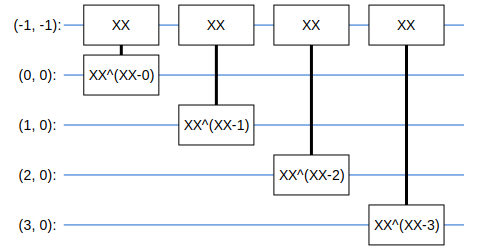

In [19]:
# Defining Quantum Neural Network (qNN) architecture

class CircLayerBuilder():
# Define class that adds a layer comprising n instances of the same quantum gate to a given circuit.
# In each such layer, each data qubit acts on the readout qubit
    
    def __init__(self, data_qbits, readout_qbit):
    # Constructor method
        self.data_qbits = data_qbits
        self.readout_qbit = readout_qbit
        
    def add_layer(self, circ, gate, prefix):
    # Given caller object (self) with n data qubits, adds a layer of n quantum gates specified 
    # by 'gate' acting on all i = 1, 2, ..., n qubits in self.data_qbits to circuit specified by 
    # 'circ', each gate being labeled with prefix specified by 'prefix'
    
    # i.e., this layer applies binary operation specified by gate acting on readout qbit and each individual data qbit
        for i, qbit in enumerate(self.data_qbits):
            label = sympy.Symbol(prefix + '-' + str(i))
            circ.append(gate(qbit, self.readout_qbit)**label)
            
# Demo methods from CircLayerBuilder class
demo_build = CircLayerBuilder(data_qbits = cirq.GridQubit.rect(4, 1), readout_qbit = cirq.GridQubit(-1, -1))
circuit = cirq.Circuit()
demo_build.add_layer(circuit, gate = cirq.XX, prefix='XX')
# Display demo circuit
print("\n==================== DISPLAYING DEMO qNN LAYER CIRCUIT  ====================")
SVGCircuit(circuit)


==================== DISPLAYING qNN MODEL CIRCUIT  ====================


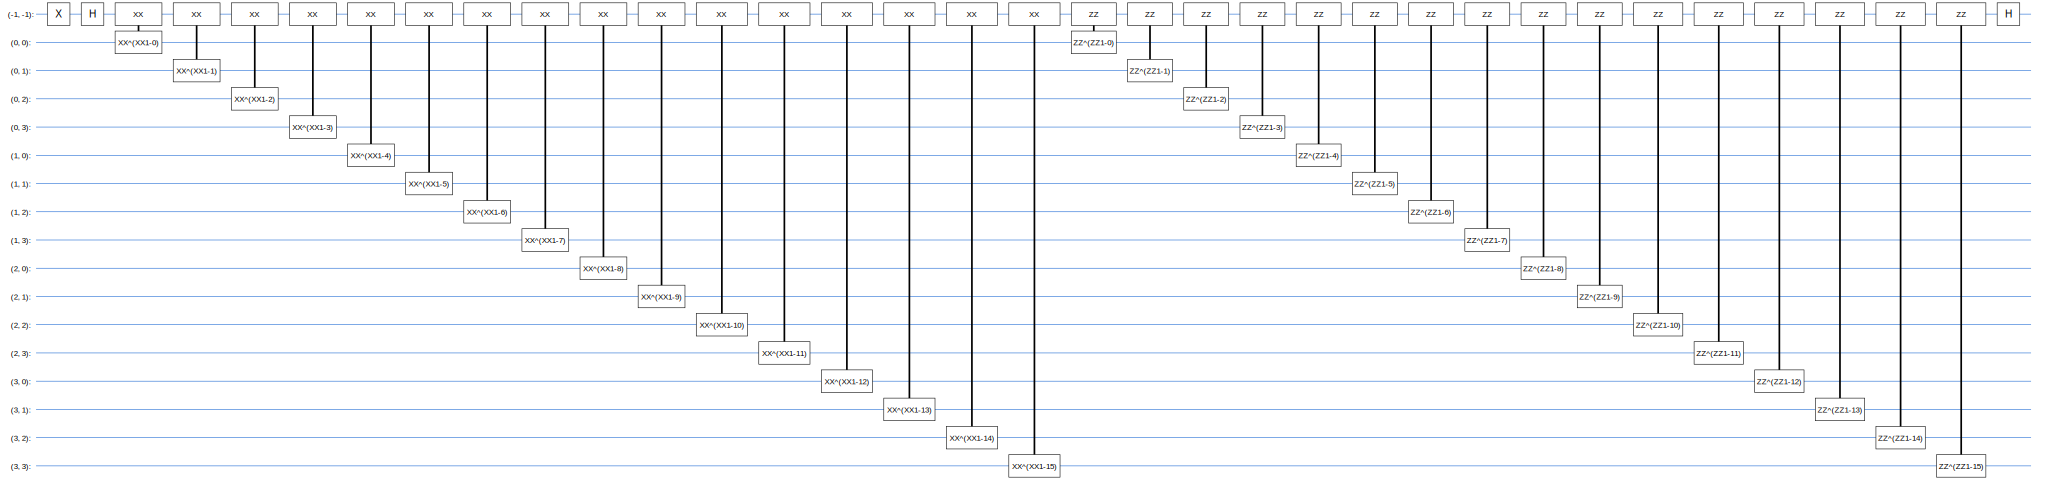

In [20]:
# Continue defining methods for building qNN model architecture

def create_quantum_model():
# Create circuit representation of a simple qNN model with corresponding readout operation (aka output neuron)
    data_qbits = cirq.GridQubit.rect(4, 4) # qubit grid comprising image data
    readout_qbit = cirq.GridQubit(-1, -1) # single output qubit positioned at (-1, -1) on circuit grid
    circuit = cirq.Circuit()
    
    # preprocess quantum state of readout qubit by applying gate operations 
    circuit.append(cirq.X(readout_qbit)) # pauli X gate operation on readout
    circuit.append(cirq.H(readout_qbit)) # Hadamard gate operation on readout
    
    # initialize circuit layer builder with corresponding data and output qubits for this qNN model
    build = CircLayerBuilder(data_qbits = data_qbits, readout_qbit = readout_qbit)
    
    # add layers to qNN model circuit (selecting XX, ZZ gates mentioned in Farhi et al)
    build.add_layer(circuit, cirq.XX, "XX1") # apply XX gate on data qubits & readout qubit
    build.add_layer(circuit, cirq.ZZ, "ZZ1") # apply ZZ gate on data qubits & readout qubit
    
    # post-process readout qubit by applying Hadamard gate (quantum superposition of states)
    circuit.append(cirq.H(readout_qbit))
    return circuit, cirq.Z(readout_qbit) # return circuit for qNN model and measurement for resultant qubit


# instantiate basic qNN model and corresponding readout qubit (aka "output neuron")
model_circ, model_result = create_quantum_model()

# wrap qNN model circuit in TensorFlow Quantum keras model
# input layer for tf.keras.Sequential will be given qubit representation of image data contained in model_circ
# and output layer will return resultant qubit given by model_result
model = tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype = tf.string), tfq.layers.PQC(model_circ, model_result)])
print("\n==================== DISPLAYING qNN MODEL CIRCUIT  ====================")
SVGCircuit(model_circ)

In [21]:
# Data preprocessing and custom method definitions for using hinge loss for qNN

def hinge_accuracy(y_true, y_pred):
# Custom definiton of hinge accuracy used to report performance of qNN's predictions y_pred 
# on data set with true labels y_true
    # convert labels in y_true and y_pred to boolean values satisfying condition: y_true, y_pred > 0.0
    y_true = tf.squeeze(y_true) > 0.0 # tf.squeeze return same tensor with size 1 dimensions removed
    y_pred = tf.squeeze(y_pred) > 0.0 # tf.squeeze return same tensor with size 1 dimensions removed
    result = tf.cast(y_true == y_pred, tf.float32) # recast resulting accuracy as tensor containing numerical values
    return tf.reduce_mean(result) # return average of the values in result

# preprocess labels by converting values from boolean to range [-1, 1]
y_train_hinge = 2.0*y_train_rmcon - 1.0
y_test_hinge = 2.0*y_test - 1.0

In [22]:
# qNN model compilation & summary

# compile final qNN model
model.compile(loss=tf.keras.losses.Hinge(), optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

# display model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_2 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# train qNN model

epochs = 10
batch = 32
num_examples = len(x_train_tfq) # subject to change based on training time

# use subsets of training set for qNN for variable wait times for training
x_train_qNNsub = x_train_tfq[:num_examples]
y_train_qNNsub = y_train_hinge[:num_examples]

print("\n==================== FITTING qNN ON 4x4 PIXEL MNIST DATA  ====================")
# obtain training history for qNN
qnn_hist = model.fit(x_train_qNNsub, y_train_qNNsub, batch_size=32, epochs=epochs,
      verbose=1, validation_data=(x_test_tfq, y_test_hinge))

# obtain test results for qNN
qnn_results = model.evaluate(x_test_tfq, y_test)


==================== FITTING qNN ON 4x4 PIXEL MNIST DATA  ====================
Epoch 1/10
324/324 [==============================] - 344s 1s/step - loss: 0.2905 - hinge_accuracy: 0.9006 - val_loss: 0.2895 - val_hinge_accuracy: 0.9012
Epoch 2/10
324/324 [==============================] - 414s 1s/step - loss: 0.2892 - hinge_accuracy: 0.8969 - val_loss: 0.2921 - val_hinge_accuracy: 0.9017
Epoch 3/10
324/324 [==============================] - 681s 2s/step - loss: 0.2891 - hinge_accuracy: 0.8993 - val_loss: 0.2914 - val_hinge_accuracy: 0.9007
Epoch 4/10
324/324 [==============================] - 662s 2s/step - loss: 0.2888 - hinge_accuracy: 0.8989 - val_loss: 0.2863 - val_hinge_accuracy: 0.9017
Epoch 5/10
324/324 [==============================] - 682s 2s/step - loss: 0.2885 - hinge_accuracy: 0.8982 - val_loss: 0.2897 - val_hinge_accuracy: 0.9012
Epoch 6/10
324/324 [==============================] - 660s 2s/step - loss: 0.2877 - hinge_accuracy: 0.9008 - val_loss: 0.2875 - val_hinge_accurac

/Users/edenzackey/anaconda3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


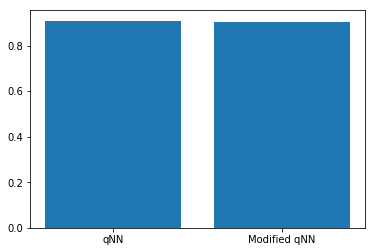

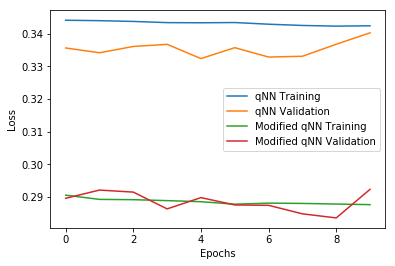

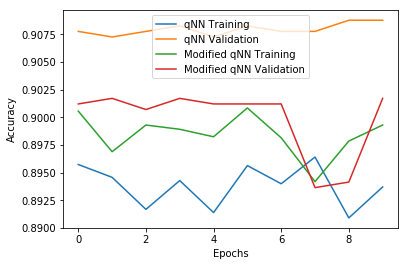

In [28]:
# Plot base model and new model results

# copy base model results from other notebook
q1_res = 0.9087701439857483
qnn1_loss = [0.34419289231300354, 0.3440631330013275, 0.3438284993171692, 0.34346142411231995, 0.34341877698898315, 0.34348756074905396, 0.34297600388526917, 0.3425918221473694, 0.3423813283443451, 0.34249237179756165]
qnn1_val_loss = [0.33568185567855835, 0.33421334624290466, 0.33614206314086914, 0.3367970585823059, 0.3324228525161743, 0.33577266335487366, 0.33289259672164917, 0.33313053846359253, 0.33681902289390564, 0.34032705426216125]
qnn1_acc = [0.8957368731498718, 0.8945794701576233, 0.891685962677002, 0.8942901492118835, 0.8913965821266174, 0.8956404328346252, 0.894000768661499, 0.8964120149612427, 0.8909143805503845, 0.8937114477157593]
qnn1_val_acc = [0.9077621102333069, 0.9072580933570862, 0.9077621102333069, 0.9082661271095276, 0.9072580933570862, 0.9082661271095276, 0.9077621102333069, 0.9077621102333069, 0.9087701439857483, 0.9087701439857483]



sns.barplot(["qNN", "Modified qNN"],[q1_res, qnn_results[1]])
plt.bar(["Base qNN", "Modified qNN"], [q1_res, qnn_results[1]])
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(qnn1_loss)
plt.plot(qnn1_val_loss)
plt.plot(qnn_hist.history['loss'])
plt.plot(qnn_hist.history['val_loss'])
plt.legend(['qNN Training', 'qNN Validation', 'Modified qNN Training', 'Modified qNN Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(qnn1_acc)
plt.plot(qnn1_val_acc)
plt.plot(qnn_hist.history['hinge_accuracy'])
plt.plot(qnn_hist.history['val_hinge_accuracy'])
plt.legend(['qNN Training', 'qNN Validation', 'Modified qNN Training', 'Modified qNN Validation'])


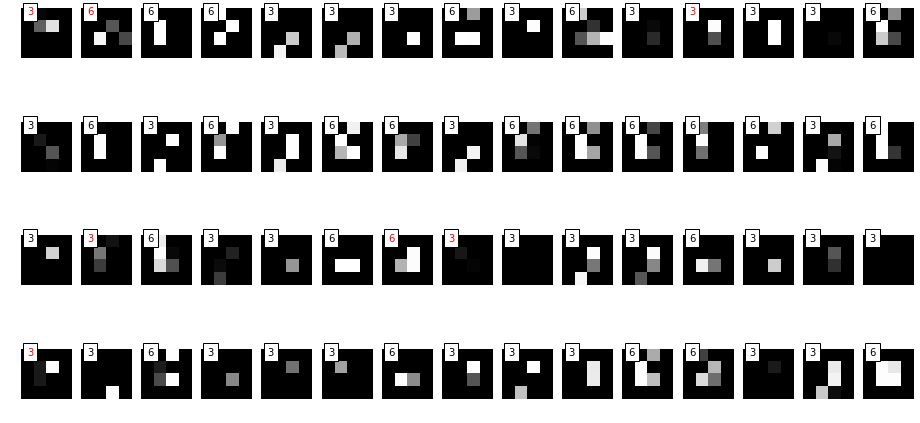

In [22]:
def show_results(model):
    rows = 4
    columns = 15
    sliced = rows*columns
    predicted = model.predict(x_test_tfq[:sliced])

    plt.figure(figsize=(16,8))
    for i in range(sliced):
        plt.subplot(rows, columns, i+1)
        plt.imshow(x_test_small[i, :, :, 0], cmap='gray', vmin=0.0, vmax=1.0)
        color = 'black' if y_test[i] == (math.ceil(predicted[i]) > 0) else 'red'
        res = 6
        if math.ceil(predicted[i]) > 0:
            res = 3
        plt.text(0, 0, res, color=color, 
                 bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

#show_results(model)
show_results(model)

In [13]:
# list TFQ's supported gates that can be experimented with in new qNN model
tfq.util.get_supported_gates()

{cirq.X: 1,
 cirq.XX: 2,
 cirq.Y: 1,
 cirq.YY: 2,
 cirq.Z: 1,
 cirq.ZZ: 2,
 cirq.H: 1,
 cirq.CZ: 2,
 cirq.CNOT: 2,
 cirq.SWAP: 2,
 cirq.ISWAP: 2,
 cirq.FSimGate(theta=0.123, phi=0.456): 2,
 cirq.I: 1,
 cirq.PhasedXPowGate(phase_exponent=0.123): 1,
 cirq.PhasedISwapPowGate(phase_exponent=0.123): 2}


==================== DISPLAYING qNN MODEL CIRCUIT  ====================


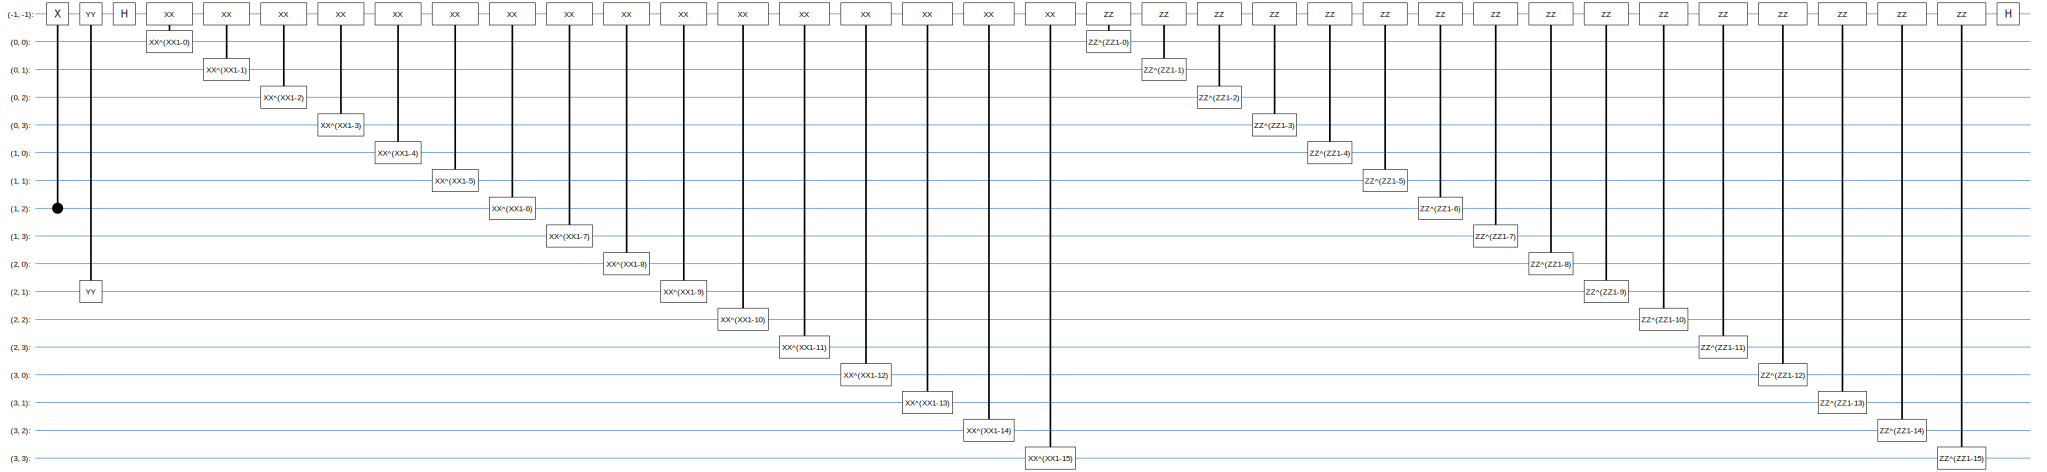

In [14]:
# Continue defining methods for building qNN model architecture

def create_quantum_model2():
# Create circuit representation of a simple qNN model with corresponding readout operation (aka output neuron)
    data = cirq.GridQubit.rect(4, 4) # qubit grid comprising image data
    readout = cirq.GridQubit(-1, -1) # single output qubit positioned at (-1, -1) on circuit grid
    circuit = cirq.Circuit()
    
    # preprocess quantum state of readout qubit by applying gate operations 
    circuit.append(cirq.CNOT(data[6], readout)) # controlled pauli X gate operation on readout
    #CY = cirq.ControlledGate(cirq.Y)
    circuit.append(cirq.YY(data[9], readout)) # controlled pauli Y gate operation on readout
    circuit.append(cirq.H(readout)) # Hadamard gate operation on readout
    
    # initialize circuit layer builder with corresponding data and output qubits for this qNN model
    build = CircLayerBuilder(data_qbits = data, readout_qbit = readout)
    
    # add layers to qNN model circuit (selecting XX, ZZ gates mentioned in Farhi et al)
    build.add_layer(circuit, cirq.XX, "XX1") # apply XX gate on data qubits & readout qubit
    build.add_layer(circuit, cirq.ZZ, "ZZ1") # apply ZZ gate on data qubits & readout qubit
    
    # post-process readout qubit by applying Hadamard gate (quantum superposition of states)
    circuit.append(cirq.H(readout))
    return circuit, cirq.Z(readout) # return circuit for qNN model and measurement for resultant qubit


# instantiate basic qNN model and corresponding readout qubit (aka "output neuron")
model_circ2, model_result2 = create_quantum_model2()

# wrap qNN model circuit in TensorFlow Quantum keras model
# input layer for tf.keras.Sequential will be given qubit representation of image data contained in model_circ
# and output layer will return resultant qubit given by model_result
model2 = tf.keras.Sequential([tf.keras.layers.Input(shape=(), dtype = tf.string), tfq.layers.PQC(model_circ2, model_result2)])
print("\n==================== DISPLAYING qNN MODEL CIRCUIT  ====================")
SVGCircuit(model_circ2)

In [26]:
# compile final qNN model
model2.compile(loss=tf.keras.losses.Hinge(), optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

# display model summary
print(model2.summary())

# train second modified qNN model

epochs = 10
batch = 32
num_examples = len(x_train_tfq) # subject to change based on training time

# use subsets of training set for qNN for variable wait times for training
x_train_qNNsub = x_train_tfq[:num_examples]
y_train_qNNsub = y_train_hinge[:num_examples]

print("\n==================== FITTING qNN ON 4x4 PIXEL MNIST DATA  ====================")
# obtain training history for qNN
qnn_hist2 = model2.fit(x_train_qNNsub, y_train_qNNsub, batch_size=batch, epochs=epochs,
      verbose=1, validation_data=(x_test_tfq, y_test_hinge))

# obtain test results for qNN
qnn_results2 = model2.evaluate(x_test_tfq, y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_1 (PQC)                  (None, 1)                 32        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None

==================== FITTING qNN ON 4x4 PIXEL MNIST DATA  ====================
Epoch 1/10
324/324 [==============================] - 668s 2s/step - loss: 0.2931 - hinge_accuracy: 0.8954 - val_loss: 0.2824 - val_hinge_accuracy: 0.8926
Epoch 2/10
324/324 [==============================] - 629s 2s/step - loss: 0.2931 - hinge_accuracy: 0.8853 - val_loss: 0.2840 - val_hinge_accuracy: 0.8926
Epoch 3/10
324/324 [==============================] - 345s 1s/step - loss: 0.2935 - hinge_accuracy: 0.8918 - val_loss: 0.2915 - val_hinge_accuracy: 0.9012
Epoch 4/10
324/324 [==============================] - 354s 1s/step - loss: 0.2929 - hinge_accuracy: 0.

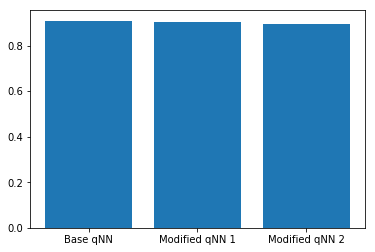

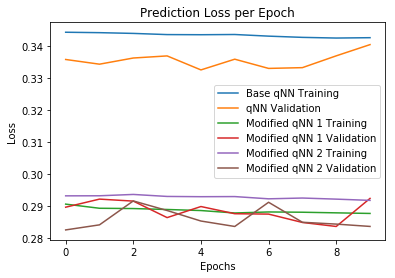

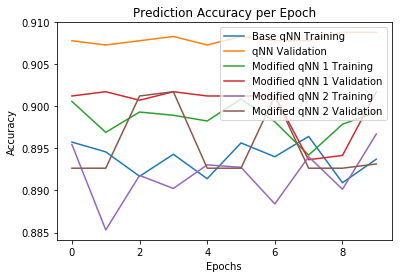

In [29]:
# Plot base model and 2 new model results

# copy base model results from other notebook
q1_res = 0.9087701439857483
qnn1_loss = [0.34419289231300354, 0.3440631330013275, 0.3438284993171692, 0.34346142411231995, 0.34341877698898315, 0.34348756074905396, 0.34297600388526917, 0.3425918221473694, 0.3423813283443451, 0.34249237179756165]
qnn1_val_loss = [0.33568185567855835, 0.33421334624290466, 0.33614206314086914, 0.3367970585823059, 0.3324228525161743, 0.33577266335487366, 0.33289259672164917, 0.33313053846359253, 0.33681902289390564, 0.34032705426216125]
qnn1_acc = [0.8957368731498718, 0.8945794701576233, 0.891685962677002, 0.8942901492118835, 0.8913965821266174, 0.8956404328346252, 0.894000768661499, 0.8964120149612427, 0.8909143805503845, 0.8937114477157593]
qnn1_val_acc = [0.9077621102333069, 0.9072580933570862, 0.9077621102333069, 0.9082661271095276, 0.9072580933570862, 0.9082661271095276, 0.9077621102333069, 0.9077621102333069, 0.9087701439857483, 0.9087701439857483]


plt.bar(["Base qNN", "Modified qNN 1", "Modified qNN 2"], [q1_res, qnn_results[1], qnn_results2[1]])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Prediction Loss per Epoch")
plt.plot(qnn1_loss)
plt.plot(qnn1_val_loss)
plt.plot(qnn_hist.history['loss'])
plt.plot(qnn_hist.history['val_loss'])
plt.plot(qnn_hist2.history['loss'])
plt.plot(qnn_hist2.history['val_loss'])
plt.legend(['Base qNN Training', 'qNN Validation', 'Modified qNN 1 Training', 'Modified qNN 1 Validation', 'Modified qNN 2 Training', 'Modified qNN 2 Validation'])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Prediction Accuracy per Epoch")
plt.plot(qnn1_acc)
plt.plot(qnn1_val_acc)
plt.plot(qnn_hist.history['hinge_accuracy'])
plt.plot(qnn_hist.history['val_hinge_accuracy'])
plt.plot(qnn_hist2.history['hinge_accuracy'])
plt.plot(qnn_hist2.history['val_hinge_accuracy'])
plt.legend(['Base qNN Training', 'qNN Validation', 'Modified qNN 1 Training', 'Modified qNN 1 Validation', 'Modified qNN 2 Training', 'Modified qNN 2 Validation'])

